# Train ReLayNet

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import h5py

from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.data_utils import get_imdb_data
from helper import * # import helper functions

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
train_data, test_data = get_imdb_data()
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 624
Test size: 156


In [5]:
# Printing Errors for CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
CUDA_LAUNCH_BLOCKING=1

In [6]:
from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.solver import Solver

bs = 50
wrkrs = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=wrkrs)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=False, num_workers=wrkrs)

param ={
        'num_channels':1,
        'num_filters':64,
        'kernel_h':3,
        'kernel_w':7,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_class':8
    }

exp_dir_name = 'RawOCTBenchmark/NotNormalised'

relaynet_model = ReLayNet(param)
solver = Solver(optim_args={"lr": 1e-2})
solver.train(relaynet_model, train_loader, val_loader, log_nth=1, num_epochs=100, exp_dir_name=exp_dir_name)

START TRAIN.
[Iteration : 0/100] - Train Loss: 37.756717681884766


RuntimeError: Input type (Variable) and weight type (Variable) should be the same

In [7]:
SEG_LABELS_LIST = [
#     {"id": -1, "name": "void", "rgb_values": [0, 0, 0]},
    {"id": 0, "name": "void", "rgb_values": [0, 0, 0]}, # black
    {"id": 1, "name": "Myocardium", "rgb_values": [255,0,0]}, # red
    {"id": 2, "name": "Endocardium", "rgb_values": [0, 0, 255]}, # blue
    {"id": 3, "name": "Fibrosis", "rgb_values": [177,10,255]}, # purple
    {"id": 4, "name": "Fat", "rgb_values": [0, 255, 0]}, # green
    {"id": 5, "name": "Dense Collagen", "rgb_values": [255, 140, 0]}, # orange
    {"id": 6, "name": "Loose Collagen", "rgb_values": [255, 255, 0]}, # yellow
    {"id": 7, "name": "Smooth Muscle", "rgb_values": [255,0,255]}# magenta/pink
]; 

def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)

/home/sim/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


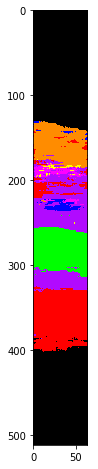

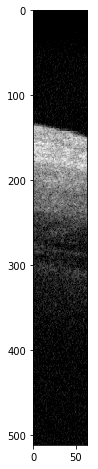

In [9]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

relaynet_model =  torch.load('models/RawOCTBenchmark/NotNormalised/relaynet_epoch30.model')

out = relaynet_model(Variable(torch.Tensor(test_data.X[10:11]).cuda(),volatile=True))
out = F.softmax(out,dim=1)
max_val, idx = torch.max(out,1)
idx = idx.data.cpu().numpy()
idx = label_img_to_rgb(idx)
plt.imshow(idx)
plt.show()

img_test = test_data.X[10:11]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.show()